In [1]:
pip install pyspark

Note: you may need to restart the kernel to use updated packages.


In [2]:
!java -version

java version "1.8.0_391"
Java(TM) SE Runtime Environment (build 1.8.0_391-b13)
Java HotSpot(TM) 64-Bit Server VM (build 25.391-b13, mixed mode)


In [3]:
import warnings
from pyspark.sql import SparkSession
sparkSession = SparkSession.builder.appName("anji") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/19 00:18:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
#creating the schema for loading the Chicago crime datase
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, DoubleType, BooleanType, TimestampType
c_schema = StructType([
    StructField("ID", IntegerType(), True),
    StructField("Case Number", StringType(), True),
    StructField("Date", StringType(), True),
    StructField("Block", StringType(), True),
    StructField("IUCR", StringType(), True),
    StructField("Primary Type", StringType(), True),
    StructField("Description", StringType(), True),
    StructField("Location Description", StringType(), True),
    StructField("Arrest", BooleanType(), True),
    StructField("Domestic", BooleanType(), True),
    StructField("Beat", StringType(), True),
    StructField("District", StringType(), True),
    StructField("Ward", IntegerType(), True),
    StructField("Community Area", IntegerType(), True),
    StructField("FBI Code", StringType(), True),
    StructField("X Coordinate", DoubleType(), True),
    StructField("Y Coordinate", DoubleType(), True),
    StructField("Year", IntegerType(), True),
    StructField("Updated On", StringType(), True),
    StructField("Latitude", DoubleType(), True),
    StructField("Longitude", DoubleType(), True),
    StructField("Location", StringType(), True)
])


In [5]:
ch=sparkSession.read.format("csv") \
    .option("header", True) \
    .option("delimiter", ",") \
    .schema(c_schema) \
    .load("Crimes_-_2001_to_Present.csv")
ch.show(5, truncate=False)
print("Number of records:", ch.count())
print("Number of columns:", len(ch.columns))

+--------+-----------+----------------------+--------------------+----+-----------------------+-----------------------------------+--------------------------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+----------------------+------------+-------------+----------------------------+
|ID      |Case Number|Date                  |Block               |IUCR|Primary Type           |Description                        |Location Description                  |Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|Updated On            |Latitude    |Longitude    |Location                    |
+--------+-----------+----------------------+--------------------+----+-----------------------+-----------------------------------+--------------------------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+----------------------+------------+-------------+----------

Number of records: 7914425
Number of columns: 22


In [6]:
from pyspark.sql.functions import isnan, when, count, col
ch.show(5)
null_counts = ch.select([
    count(when(col(c).isNull(), c)).alias(c)
    for c in ch.columns
])

pandas_null_counts = null_counts.toPandas()
print("Column wise NULL values ", pandas_null_counts)

fill_values = {
    "ID": 0,
    "X Coordinate": 0.0,
    "Y Coordinate": 0.0,
    "Description": "NA",
}

for col_name, fill_value in fill_values.items():
    ch = ch.na.fill(fill_value, [col_name])

print("DataFrame with Null Values Filled:")
ch.show(5)

+--------+-----------+--------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|                Date|               Block|IUCR|        Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+--------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
| 5741943|   HN549294|08/25/2007 09:22:...|  074XX N ROGERS AVE|0560|             ASSAULT|              SIMPLE|             

Column wise NULL values     ID  Case Number  Date  Block  IUCR  Primary Type  Description  \
0   0            0     0      0     0             0            0   

   Location Description  Arrest  Domestic  ...    Ward  Community Area  \
0                 11907       0         0  ...  614849          613476   

   FBI Code  X Coordinate  Y Coordinate  Year  Updated On  Latitude  \
0         0         90108         90108     0           0     90108   

   Longitude  Location  
0      90108     90108  

[1 rows x 22 columns]
DataFrame with Null Values Filled:
+--------+-----------+--------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|                Date|               Block|IUCR|        Primary Type|         Description|Location Description|Arrest|Domesti

In [7]:
#after filling null valus, again Checking number for nulls in dataframe column-wise
from pyspark.sql.functions import isnan, when, count, col

ch.select([
    count(when(col(c).isNull(), c)).alias(c)
    for c in ch.columns
]).show()

+---+-----------+----+-----+----+------------+-----------+--------------------+------+--------+----+--------+------+--------------+--------+------------+------------+----+----------+--------+---------+--------+
| ID|Case Number|Date|Block|IUCR|Primary Type|Description|Location Description|Arrest|Domestic|Beat|District|  Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|Updated On|Latitude|Longitude|Location|
+---+-----------+----+-----+----+------------+-----------+--------------------+------+--------+----+--------+------+--------------+--------+------------+------------+----+----------+--------+---------+--------+
|  0|          0|   0|    0|   0|           0|          0|               11907|     0|       0|   0|      47|614849|        613476|       0|           0|           0|   0|         0|   90108|    90108|   90108|
+---+-----------+----+-----+----+------------+-----------+--------------------+------+--------+----+--------+------+--------------+--------+------------+---

In [8]:
# # # Modified the data type of the Date column to TimestampType by utilizing the cast method.
from pyspark.sql.functions import to_timestamp, col
from pyspark.sql import functions as F

# Define a list of potential date format patterns
sparkSession.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")
date_format_patterns = ["MM/dd/yyyy hh:mm:ss a", "MM/dd/yyyy HH:mm:ss"]

# Create a new column with a timestamp for each format
for pattern in date_format_patterns:
    ch = ch.withColumn("Date_" + pattern, to_timestamp(col("Date"), pattern))

# Find the first non-null date from the multiple columns
ch = ch.withColumn("Date", F.coalesce(*[col("Date_" + pattern) for pattern in date_format_patterns]))

# Drop the temporary columns
for pattern in date_format_patterns:
    ch = ch.drop("Date_" + pattern)
ch.show(5)


+--------+-----------+-------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|               Date|               Block|IUCR|        Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+-------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
| 5741943|   HN549294|2007-08-25 09:22:18|  074XX N ROGERS AVE|0560|             ASSAULT|              SIMPLE|               OT

In [9]:
# filtering data for the last ten years
ch=ch.filter((ch["Year"] >= 2013))
ch.show(5)

+--------+-----------+-------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|               Date|               Block|IUCR|        Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+-------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|13203321|   JG415333|2023-09-06 17:00:00|    002XX N Wells st|1320|     CRIMINAL DAMAGE|          TO VEHICLE|PARKING LOT / GAR

In [10]:
# # Remove all the records with the following crime types:
# #'NON-CRIMINAL (SUBJECT SPECIFIED)' 'OTHER OFFENSE' 'STALKING', 'NON - CRIMINAL', 'ARSON'
from pyspark.sql.functions import col
print("Count of Before Removing all the records with crime types : ", ch.count())
crime_types_to_remove=[
    'NON-CRIMINAL (SUBJECT SPECIFIED)',
    'OTHER OFFENSE',
    'STALKING',
    'NON - CRIMINAL',
    'ARSON'
]
ch =ch.filter(~col("Primary Type").isin(crime_types_to_remove))
print("Count of after Removing all the records with crime types : ", ch.count())

Count of Before Removing all the records with crime types :  2778427


Count of after Removing all the records with crime types :  2596601


In [11]:
from pyspark.sql.functions import when, col, date_format
# Print distinct values of Primary Type before merging
ch.select("Primary Type").distinct().orderBy("Primary Type").show(truncate=False)

# Merge similar crime types
ch = ch.withColumn(
    "Primary Type",
    when(
        col("Primary Type").isin("SEX OFFENSE", "PROSTITUTION"),
        "SEX CRIME"
    ).otherwise(col("Primary Type"))
)
print("\nAfter Merging:")
ch.select("Primary Type").distinct().orderBy("Primary Type").show(truncate=False)

# Show the DataFrame
ch.show(5)

+---------------------------------+
|Primary Type                     |
+---------------------------------+
|ASSAULT                          |
|BATTERY                          |
|BURGLARY                         |
|CONCEALED CARRY LICENSE VIOLATION|
|CRIM SEXUAL ASSAULT              |
|CRIMINAL DAMAGE                  |
|CRIMINAL SEXUAL ASSAULT          |
|CRIMINAL TRESPASS                |
|DECEPTIVE PRACTICE               |
|GAMBLING                         |
|HOMICIDE                         |
|HUMAN TRAFFICKING                |
|INTERFERENCE WITH PUBLIC OFFICER |
|INTIMIDATION                     |
|KIDNAPPING                       |
|LIQUOR LAW VIOLATION             |
|MOTOR VEHICLE THEFT              |
|NARCOTICS                        |
|NON-CRIMINAL                     |
|OBSCENITY                        |
+---------------------------------+
only showing top 20 rows


After Merging:


+---------------------------------+
|Primary Type                     |
+---------------------------------+
|ASSAULT                          |
|BATTERY                          |
|BURGLARY                         |
|CONCEALED CARRY LICENSE VIOLATION|
|CRIM SEXUAL ASSAULT              |
|CRIMINAL DAMAGE                  |
|CRIMINAL SEXUAL ASSAULT          |
|CRIMINAL TRESPASS                |
|DECEPTIVE PRACTICE               |
|GAMBLING                         |
|HOMICIDE                         |
|HUMAN TRAFFICKING                |
|INTERFERENCE WITH PUBLIC OFFICER |
|INTIMIDATION                     |
|KIDNAPPING                       |
|LIQUOR LAW VIOLATION             |
|MOTOR VEHICLE THEFT              |
|NARCOTICS                        |
|NON-CRIMINAL                     |
|OBSCENITY                        |
+---------------------------------+
only showing top 20 rows

+--------+-----------+-------------------+--------------------+----+--------------------+--------------------+

In [12]:
# # # filter out records with null year values in Date column 
from pyspark.sql.functions import year
ch = ch.filter(year("Date").isNotNull())
yearly_crime_count = ch.groupBy(year("Date").alias("Year")).agg(count("*").alias("Crimes"))
# Show the yearly crime count
yearly_crime_count.show()


+----+------+
|Year|Crimes|
+----+------+
|2018|251065|
|2015|246595|
|2023|188267|
|2022|223555|
|2013|288953|
|2014|258216|
|2019|243959|
|2020|198841|
|2016|251822|
|2017|251197|
|2021|194063|
+----+------+



In [13]:
# Assuming 'ch' is your DataFrame containing crime data
ch.createOrReplaceTempView("crime_data")
x = sparkSession.sql("""
    SELECT hour(to_timestamp(Date, 'MM/dd/yyyy hh:mm:ss a')) as Hour, COUNT(*) as CrimeCount
    FROM crime_data
    GROUP BY Hour
    ORDER BY CrimeCount DESC
""")
x.show()
most_common_hour = x.first()
print(f"The hour with the highest crime count is {most_common_hour['Hour']} with {most_common_hour['CrimeCount']} crimes.")


+----+----------+
|Hour|CrimeCount|
+----+----------+
|  12|    152211|
|   0|    146922|
|  18|    145076|
|  19|    144104|
|  15|    141962|
|  17|    139085|
|  20|    138103|
|  16|    137078|
|  14|    129623|
|  21|    128869|
|  22|    126759|
|  13|    123346|
|  11|    117103|
|   9|    115080|
|  10|    113576|
|  23|    107313|
|   8|     87834|
|   1|     80938|
|   2|     70229|
|   7|     61583|
+----+----------+
only showing top 20 rows



The hour with the highest crime count is 12 with 152211 crimes.


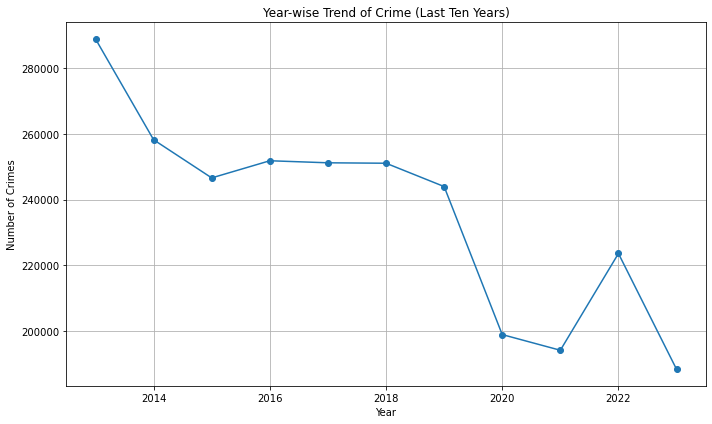

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

current_year = F.year(F.current_date())
filtered_data = ch.filter((year("Date") >= current_year - 10) & (year("Date") <= current_year))
yearly_crime_count = filtered_data.groupBy(year("Date").alias("Year")).agg(F.count("*").alias("Crimes"))
yearly_crime_count_pandas = yearly_crime_count.toPandas()
yearly_crime_count_pandas = yearly_crime_count_pandas.sort_values(by="Year")

plt.figure(figsize=(10, 6))
plt.plot(yearly_crime_count_pandas['Year'], yearly_crime_count_pandas['Crimes'], marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Number of Crimes')
plt.title('Year-wise Trend of Crime (Last Ten Years)')
plt.grid(True)
plt.tight_layout()
plt.show()


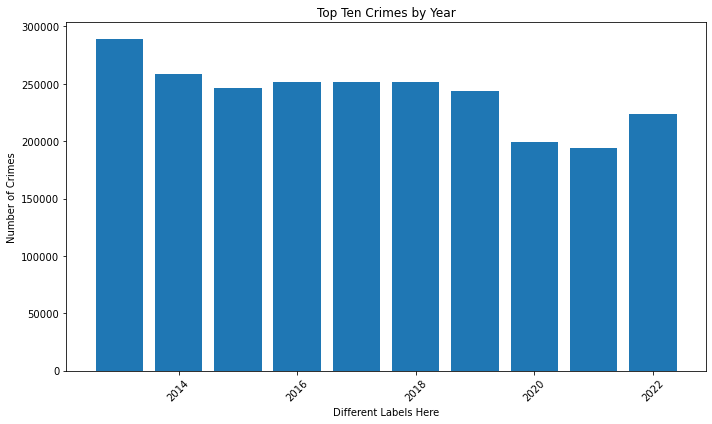

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

yearly_crime_count_pandas = yearly_crime_count.toPandas()

top_ten_crimes = yearly_crime_count_pandas.nlargest(10, 'Crimes')

plt.figure(figsize=(10, 6))
plt.bar(top_ten_crimes['Year'], top_ten_crimes['Crimes'])
plt.xlabel('Different Labels Here')
plt.ylabel('Number of Crimes')
plt.title('Top Ten Crimes by Year')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

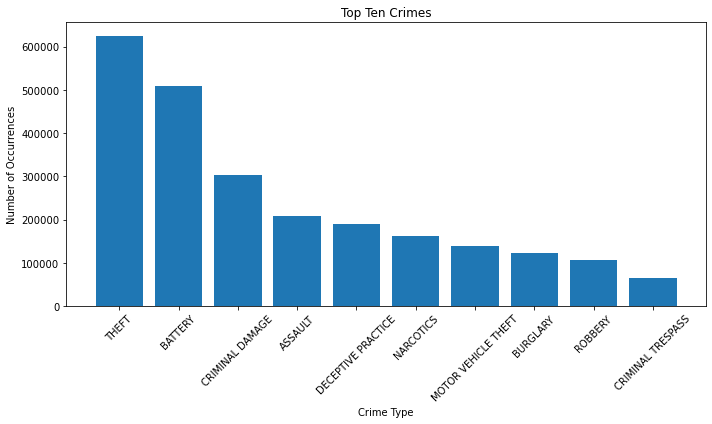

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

crime_counts = ch.groupBy("Primary Type").count()
top_ten_crimes = crime_counts.orderBy("count", ascending=False).limit(10)
top_ten_crimes_pandas = top_ten_crimes.toPandas()

plt.figure(figsize=(10, 6))
plt.bar(top_ten_crimes_pandas['Primary Type'], top_ten_crimes_pandas['count'])
plt.xlabel('Crime Type')
plt.ylabel('Number of Occurrences')
plt.title('Top Ten Crimes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
